# Segmentation

In [6]:
import sys
sys.path.append("/home/maryana/Projects/AVID_pipeline/python/UCSFSlideScan")

In [8]:
import ConfigParser
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
import numpy as np

#set random seed
from numpy.random import seed
seed(17)
from tensorflow import set_random_seed
set_random_seed(17)

from convnet.util.help_functions import *
from convnet.util.extract_patches import recompone
from convnet.util.extract_patches import recompone_overlap
from convnet.util.extract_patches import get_data_testing
from convnet.util.extract_patches import get_data_testing_overlap,get_data_segmenting_overlap

import fnmatch
from misc.imoverlay import imoverlay as imoverlay
import mahotas as mh
import skimage.io as io
import glob
import matplotlib.pyplot as plt
import cv2

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [9]:
def get_slidenet2(n_ch=3,patch_height=204,patch_width=204):
    inputs = Input(shape=(n_ch, patch_height, patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', data_format='channels_first')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(256, (1, 1), activation='relu', data_format='channels_first')(pool3)
    conv4 = Conv2D(256, (1, 1), activation='relu', data_format='channels_first')(conv4)
    up4 = UpSampling2D(size=(2, 2))(conv4)
    up4 = concatenate([conv3, up4], axis=1)
    up4 = Dropout(0.1)(up4)

    conv5 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(up4)
    conv5 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(conv5)
    up5 = UpSampling2D(size=(2, 2))(conv5)
    crop_conv6 = Cropping2D(cropping=((8, 8), (8, 8)))(conv2)
    up6 = concatenate([crop_conv6, up5], axis=1)
    up6 = Dropout(0.1)(up6)

    conv6 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(conv6)
    up7 = UpSampling2D(size=(3, 3))(conv6)
    crop_conv7 = Cropping2D(cropping=((14, 14), (14, 14)))(up7)
    up7 = concatenate([conv1, crop_conv7], axis=1)
    up7 = Dropout(0.1)(up7)

    conv7 = Conv2D(32, (1, 1), activation='relu', data_format='channels_first')(up7)
    conv7 = Conv2D(2, (1, 1), activation='relu', data_format='channels_first')(conv7)
    conv7 = Dropout(0.1)(conv7)

    conv7 = core.Reshape((2, 200 * 200))(conv7)
    conv7 = core.Permute((2, 1))(conv7)
    softmax = core.Activation('softmax')(conv7)
    #softmax = core.Activation('sigmoid')(conv7)
    model = Model(input=inputs, output=softmax)

    #sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = False)
    #adam = Adam(lr=0.0021) #AT100
    #adam = Adam(lr=0.002701)  # AT8
    adam = Adam(lr=0.005) #MC1

    #sgd = SGD(lr=0.005)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')
    #model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy', dice_coef])

    model.summary()

    return model

In [10]:
TISSUE_THRESH = 0.05

def get_num_pix_tissue(img):  # assumes RGB image
    tmp_img = img[:, :, 0] + img[:, :, 1] + img[:, :, 2]
    tmp_nnz_b = tmp_img.flatten().nonzero()
    nnz_b = float(len(tmp_nnz_b[0]))  # number of non-zero pixel in img
    return nnz_b


def get_folder_list(root_dir):
    folder_list = []

    for root, dir, files in os.walk(root_dir):
        if fnmatch.fnmatch(root, '*heat_map'):
            folder_list.append(root)

    return folder_list

In [11]:
def run_segmentation(root_dir,config_file):
    nError = 0

    dir_list = get_folder_list(root_dir)

    #read config
    config = ConfigParser.RawConfigParser()
    config.read(config_file)
    path_project = config.get('data paths', 'path_project')
    path_model = os.path.join(path_project, config.get('data paths', 'path_model'))

    # dimension of the patches
    patch_height = int(config.get('data attributes', 'patch_height'))
    patch_width = int(config.get('data attributes', 'patch_width'))
    mask_dim = (200, 200)

    # model name
    name_experiment = config.get('experiment name', 'name')
    average_mode = config.getboolean('testing settings', 'average_mode')

    # Load the saved model
    model = model_from_json(open(os.path.join(path_model,name_experiment + '_architecture.json')).read())
    model.load_weights(os.path.join(path_model,name_experiment + '_best_weights.h5'))

    stride_height = 90
    stride_width = 90

    for folder in dir_list:

        #check if tiles folder exists
        tiles_dir = os.path.join(folder,'seg_tiles')
        if not os.path.exists(tiles_dir):
            print('Error: tiles folder {} does not exist.'.format(tiles_dir))
            continue

        #create output folder
        out_dir = os.path.join(folder,'TAU_seg_tiles')
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)

        print('*** Processing files in folder {}'.format(folder))

        #get a list of tif files
        files = glob.glob(os.path.join(tiles_dir,'*.tif'))
        nTotal = len(files)
        print('{} tile(s) to segment.'.format(nTotal))

        for fname in files:

            basename = os.path.basename(fname)
            #overlay = imoverlay(orig_img,bw,[0.3,1,0.3])
            #out_name = os.path.join(out_dir,basename[0:-4]+'_over.tif')
            out_name_seg = os.path.join(out_dir,basename[0:-4]+'_mask.tif')
            out_name_prob = os.path.join(out_dir,basename[0:-4]+'_prob.npy')

            test_imgs_original = os.path.join(tiles_dir,fname)
            print('Segmenting image {}.'.format(test_imgs_original))

            # Load the data and divide in patches
            try:
                #load image to segment
                orig_img = io.imread(test_imgs_original)
            except:
                nError += 1
                print("Error opening file {}".format(test_imgs_original))
                continue

            #check if image has enough tissue
            npix_tissue = get_num_pix_tissue(orig_img)
            percent_tissue = npix_tissue / (orig_img.shape[0] * orig_img.shape[1])
            if percent_tissue < TISSUE_THRESH:
                print('Image has too little tissue. Skipping.')
                continue

            #load mean image for pre-processing
            mean_img_path = os.path.join(path_project,config.get('data paths', 'mean_image'))

            #pad sides
            orig_img_pad = pad_image(orig_img.copy(), patch_height, patch_width)
            
            #break image into patches
            patches_imgs_test, new_height, new_width, masks_test = get_data_segmenting_overlap(
                    test_img_original=orig_img_pad.astype('float'),  # image path to segment
                    Imgs_to_test=int(config.get('testing settings', 'full_images_to_test')),
                    mean_image_path=mean_img_path,
                    patch_height=patch_height,
                    patch_width=patch_width,
                    stride_height=stride_height,
                    stride_width=stride_width,
                    is_color=True
            )

            #calculate the predictions
            start = time.clock()
            predictions = model.predict(patches_imgs_test, batch_size=32, verbose=2)
            end = time.clock()
            print("**Time per image: {} ".format((end-start)/32))
            print "predicted images size :"
            print predictions.shape

            #convert the prediction arrays in corresponding images
            pred_patches = pred_to_imgs(predictions, mask_dim[0], mask_dim[1], "original")

            new_pred_patches = np.zeros((pred_patches.shape[0],1,patch_height,patch_width))
            nP = pred_patches.shape[0]
            for p in range(nP):
                tmp = pred_patches[p,0,...]
                tmp = cv2.resize(tmp,(patch_height,patch_width),interpolation=cv2.INTER_NEAREST)
                new_pred_patches[p,0,...] = tmp

            if average_mode == True:
                pred_imgs = recompone_overlap(new_pred_patches, new_height, new_width, stride_height,
                                              stride_width)  # predictions
            else:
                pred_imgs = recompone(pred_patches, 13, 12)  # predictions

            img = pred_imgs[0,0,...]

            #remove padding 1
            pad_r1 = new_height - orig_img_pad.shape[0]
            pad_c1 = new_width - orig_img_pad.shape[1]
            img = img[0:img.shape[0]-pad_r1, 0:img.shape[1]-pad_c1,...]

            #remove padding 2
            img = img[patch_height:img.shape[0]-patch_height, patch_width:img.shape[1]-patch_width,...]

            #threshold
            mask = img > 0.7 #img has class probabilities
            #bw = mh.bwperim(mask)

            print('Saving probability file {}'.format(out_name_prob))
            np.save(out_name_prob,img)

            #mask out background just in case
            mask_bkg = orig_img[...,0] < 1.
            mask[mask_bkg == True] = False

            print('Saving {}'.format(out_name_seg))
            io.imsave(out_name_seg,(mask*255).astype('uint8'))

        print("Segmentation ended with {} errors".format(nError))

# Segment Slide

In [13]:
root_dir = '/home/maryana/storage2/Posdoc/AVID/AV13/AT100/full_res/test/'
config_file = '/home/maryana/storage2/Posdoc/AVID/AV13/MC1/slidenet_2classes/configuration_avid_ucsf_2classes.txt'
run_segmentation(root_dir,config_file)

Error: tiles folder /home/maryana/storage2/Posdoc/AVID/AV13/AT100/full_res/test/AV1_AT100_360/heat_map/seg_tiles does not exist.


# Segment Test and Validation Datasets

In [14]:
root_dir = '/home/maryana/storage2/Posdoc/AVID/AT100/results'
config_file = '/home/maryana/storage2/Posdoc/AVID/AT100/slidenet_2classes/configuration_avid_slidenet_2class_204px.txt'
run_segmentation(root_dir,config_file)

*** Processing files in folder /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map
25 tile(s) to segment.
Segmenting image /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/seg_tiles/patch_a6da76ac-6d05-11e9-81c1-484d7ede57b2.tif.

the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.552495524319 - 0.092880471931
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
tes

test PATCHES images range (min-max): -0.383868073338 - 0.310235790993
**Time per image: 0.014639125 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x1464 each)
(1, 1, 1464, 1464)
Saving probability file /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/TAU_seg_tiles/patch_a6da76a2-6d05-11e9-81c1-484d7ede57b2_prob.npy
Saving /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/TAU_seg_tiles/patch_a6da76a2-6d05-11e9-81c1-484d7ede57b2_mask.tif
Segmenting image /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/seg_tiles/patch_a6da76ab-6d05-11e9-81c1-484d7ede57b2.tif.


/home/maryana/.local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/TAU_seg_tiles/patch_a6da76a2-6d05-11e9-81c1-484d7ede57b2_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)



the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.376024936083 - 0.0984848678382
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.376024936083 - 0.0984848678382
**Time per image: 0.01376440625 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 146

/home/maryana/.local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/TAU_seg_tiles/patch_a6da76a6-6d05-11e9-81c1-484d7ede57b2_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)



the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.281907289025 - 0.263176967464
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.281907289025 - 0.263176967464
**Time per image: 0.014209125 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x14


the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.22868815552 - 0.337686771385
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.22868815552 - 0.337686771385
**Time per image: 0.0142946875 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x146

/home/maryana/.local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/TAU_seg_tiles/patch_77f99f49-6d05-11e9-81c1-484d7ede57b2_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)



the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.321122975299 - 0.435725987071
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.321122975299 - 0.435725987071
**Time per image: 0.01442253125 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x

/home/maryana/.local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/TAU_seg_tiles/patch_77f99f46-6d05-11e9-81c1-484d7ede57b2_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)



the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.395632779221 - 0.188667163542
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.395632779221 - 0.188667163542
**Time per image: 0.014712125 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x14

**Time per image: 0.01423109375 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x1464 each)
(1, 1, 1464, 1464)
Saving probability file /home/maryana/storage2/Posdoc/AVID/AT100/results/validation/heat_map/TAU_seg_tiles/patch_c45a744d-6d05-11e9-81c1-484d7ede57b2_prob.npy
Saving /home/maryana/storage2/Posdoc/AVID/AT100/results/validation/heat_map/TAU_seg_tiles/patch_c45a744d-6d05-11e9-81c1-484d7ede57b2_mask.tif
Segmenting image /home/maryana/storage2/Posdoc/AVID/AT100/results/validation/heat_map/seg_tiles/patch_c45a7449-6d05-11e9-81c1-484d7ede57b2.tif.

the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim

/home/maryana/.local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /home/maryana/storage2/Posdoc/AVID/AT100/results/validation/heat_map/TAU_seg_tiles/patch_c45a7449-6d05-11e9-81c1-484d7ede57b2_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)



the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.552495524319 - 0.200431869424
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.552495524319 - 0.200431869424
**Time per image: 0.01414953125 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x

/home/maryana/.local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /home/maryana/storage2/Posdoc/AVID/AT100/results/validation/heat_map/TAU_seg_tiles/patch_c45a744c-6d05-11e9-81c1-484d7ede57b2_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)



the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.303197959442 - 0.167390275853
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.303197959442 - 0.167390275853
**Time per image: 0.01445096875 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x

/home/maryana/.local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /home/maryana/storage2/Posdoc/AVID/AT100/results/validation/heat_map/TAU_seg_tiles/patch_82790379-6d05-11e9-81c1-484d7ede57b2_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)



the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)

test images shape:
(1, 3, 1464, 1464)

test mask shape:
(1, 3)
test images range (min-max): -0.552495524319 - 0.259255398836
test masks are within 0-1

Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225

test PATCHES images shape:
(225, 3, 204, 204)
test PATCHES images range (min-max): -0.552495524319 - 0.259255398836
**Time per image: 0.01470315625 
predicted images size :
(225, 40000, 2)
N_patches_h: 15
N_patches_w: 15
N_patches_img: 225
According to the dimension inserted, there are 1 full images (of 1464x

# Plot ROC and Precision-Recall curves

In [44]:
from convnet.util.scores import *
import glob
import skimage.io as io
from skimage import img_as_ubyte


def convert_mask2binary(g_truth):
    # process mask
    g_truth = img_as_ubyte(g_truth)
    mask_bkg = g_truth[..., 2] == 10
    mask_gm = g_truth[..., 2] == 255
    mask_thread = g_truth[..., 2] == 130
    mask_cell = g_truth[..., 2] == 0

    mask_fore = (mask_cell | mask_thread) * 255
    mask_bkg = (mask_gm | mask_bkg) * 255  # black background and GM together
    mask_fore_bin = mask_fore >= 255
    mask_back_bin = mask_bkg >= 255

    mask = np.concatenate((mask_fore_bin[...,np.newaxis],mask_back_bin[...,np.newaxis]),axis=2)

    return mask

def get_file_pairs(seg_dir,mask_dir):
    file_map = {}
    seg_list = glob.glob(os.path.join(seg_dir,'*.npy'))
    for prob_file in seg_list:
        basename = os.path.basename(prob_file)
        parcname = basename[:-9]
        mask_name = parcname + '_mask.tif' #ground truth mask, not segmented mask
        mask_name = os.path.join(mask_dir,mask_name)

        file_map[prob_file] = mask_name

    return file_map


def compute_stats(file_map,prob_thres):
    dice = 0
    prec = 0
    rec = 0
    f1 = 0
    fpr = 0

    nFiles = len(file_map.keys())
    for prob_file in file_map.keys():

        prob_map = np.load(prob_file)
        seg_mask = prob_map >= prob_thres

        gt_file = file_map[prob_file]
        gd_truth = io.imread(gt_file)
        if gd_truth.ndim > 2: #multichannel mask must be converted
            gd_truth = convert_mask2binary(gd_truth)

        dice += dice_coef_simple(gd_truth[...,0],seg_mask) # gd_truth[...,0] == foreground

        prec += precision(gd_truth[...,0],seg_mask)
        rec += recall(gd_truth[...,0],seg_mask)
        f1 += F1(prec,rec)
        fpr += FPR(gd_truth[...,0],seg_mask)

    dice /= nFiles
    prec /= nFiles
    rec /= nFiles
    f1 /= nFiles
    fpr /= nFiles

    return dice,prec,rec,f1,fpr


def run_compute_stats(seg_dir,gt_dir,out_file):
    file_map = get_file_pairs(seg_dir,gt_dir)

    probs = np.linspace(1,0,num=20)

    n_probs = len(probs)
    dice_arr = np.zeros(n_probs)
    prec_arr = np.zeros(n_probs)
    rec_arr = np.zeros(n_probs)
    f1_arr = np.zeros(n_probs)
    fpr_arr = np.zeros(n_probs)

    for i in range(n_probs):
        prob = probs[i]
        
        print('Probability threshold: {:.2f}'.format(prob))
        
        dice, prec, rec, f1, fpr = compute_stats(file_map,prob)
        dice_arr[i] = dice
        prec_arr[i] = prec
        rec_arr[i] = rec
        f1_arr[i] = f1
        fpr_arr[i] = fpr


    print('Saving {}'.format(out_file))
    out_arr = np.concatenate((dice_arr[:,np.newaxis],prec_arr[:,np.newaxis],
                              rec_arr[:,np.newaxis],f1_arr[:,np.newaxis],fpr_arr[:,np.newaxis]),axis=1)
    np.save(out_file,out_arr)

 

In [41]:
#compute values for testing dataset
seg_dir = '/home/maryana/storage2/Posdoc/AVID/AT100/results/testing/heat_map/TAU_seg_tiles'
gt_dir = '/home/maryana/storage2/Posdoc/AVID/AT100/db_testing/masks'
stats_file = '/home/maryana/storage2/Posdoc/AVID/AT100/results/at100_stats.npy'
run_compute_stats(seg_dir,gt_dir,stats_file)

Probability threshold: 1.0
Probability threshold: 0.95
Probability threshold: 0.89


KeyboardInterrupt: 

In [45]:
#compute values for validation dataset
seg_dir = '/home/maryana/storage2/Posdoc/AVID/AT100/results/validation/heat_map/TAU_seg_tiles'
gt_dir = '/home/maryana/storage2/Posdoc/AVID/AT100/db_validation/masks'
stats_file = '/home/maryana/storage2/Posdoc/AVID/AT100/results/at100_stats.npy'
run_compute_stats(seg_dir,gt_dir,stats_file)

Probability threshold: 1.00
Probability threshold: 0.95
Probability threshold: 0.89
Probability threshold: 0.84
Probability threshold: 0.79
Probability threshold: 0.74
Probability threshold: 0.68
Probability threshold: 0.63
Probability threshold: 0.58
Probability threshold: 0.53
Probability threshold: 0.47
Probability threshold: 0.42
Probability threshold: 0.37
Probability threshold: 0.32
Probability threshold: 0.26
Probability threshold: 0.21
Probability threshold: 0.16
Probability threshold: 0.11
Probability threshold: 0.05
Probability threshold: 0.00
Saving /home/maryana/storage2/Posdoc/AVID/AT100/results/at100_stats.npy


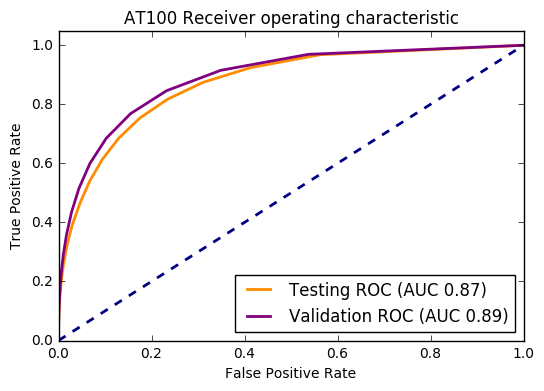

In [46]:
from sklearn.metrics import auc

test_stats = np.load('/home/maryana/storage2/Posdoc/AVID/AT100/results/testing/AT100_testing_stats.npy')
val_stats = np.load('/home/maryana/storage2/Posdoc/AVID/AT100/results/validation/AT100_validation_stats.npy')
fig1_name = '/home/maryana/storage2/Posdoc/AVID/AT100/results/validation/AT100_ROC.png'

auc_test = auc(test_stats[:, 5], test_stats[:, 3])
auc_val = auc(val_stats[:, 5], val_stats[:, 3])

plt.figure()
lw = 2
plt.plot(test_stats[:, 5], test_stats[:, 3], color='darkorange',lw=lw, label='Testing ROC (AUC {:.2f})'.format(auc_test))
plt.plot(val_stats[:, 5], val_stats[:, 3], color='purple', lw=lw, label='Validation ROC (AUC {:.2f})'.format(auc_val))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AT100 Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.savefig(fig1_name)

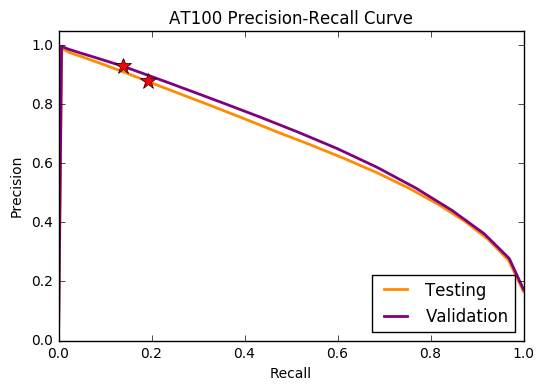

In [48]:
def find_nearest1(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

thres = 0.7

test_stats = np.load('/home/maryana/storage2/Posdoc/AVID/AT100/results/testing/AT100_testing_stats.npy')
val_stats = np.load('/home/maryana/storage2/Posdoc/AVID/AT100/results/validation/AT100_validation_stats.npy')
fig1_name = '/home/maryana/storage2/Posdoc/AVID/AT100/results/validation/AT100_precision_recall.png'

prec_t = test_stats[:, 2]
recall_t = test_stats[:, 3]
prec_v = val_stats[:, 2]
recall_v = val_stats[:, 3]

probs = np.linspace(1, 0, num=20)
index = find_nearest1(probs,thres)

x_thres_t = recall_t[index]
y_thres_t = prec_t[index]
x_thres_v = recall_v[index]
y_thres_v = prec_v[index]

plt.figure()
lw = 2
plt.plot(recall_t,prec_t, color='darkorange',lw=lw, label='Testing')
plt.plot(recall_v,prec_v,  color='purple', lw=lw, label='Validation')
plt.plot(x_thres_t, y_thres_t, color='red', lw=lw, marker='*', markersize=12) # Testing threshold tirado dos vetores prec/recall usando o index de probs mais proximos do threshold = 0.7
plt.plot(x_thres_v, y_thres_v, color='red', lw=lw, marker='*', markersize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AT100 Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

plt.savefig(fig1_name)

# Class Activation Maps and Perturbation Tests

In [49]:
from convnet.util.help_functions import *
from convnet.util.extract_patches import get_data_testing_overlap,get_data_segmenting_overlap

from keras import backend as K
from keras.activations import linear
import tensorflow as tf
from tensorflow.python.framework import ops
from misc.TiffTileLoader import sub2ind,ind2sub
from misc.imoverlay import  imoverlay
from mahotas import bwperim
import matplotlib as mpl
import matplotlib.cm as cm
from skimage import img_as_ubyte

def build_model():
    model = model_from_json(open(
        '/home/maryana/storage2/Posdoc/AVID/AT100/slidenet_2classes/models/AT100_slidenet_architecture.json').read())
    model.load_weights(
        '/home/maryana/storage2/Posdoc/AVID/AT100/slidenet_2classes/models/AT100_slidenet_best_weights.h5')
    return model

def grad_cam(input_model, input_data, cls, layer_name, fore_or_back = 0):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls, fore_or_back]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([input_data])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    output = np.transpose(output,axes=(1,2,0))
    grads_val = np.transpose(grads_val,axes=(1,2,0))

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (204, 204), interpolation=cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 10e-20)
    return cam

def deprocess_image(x):
    """From:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # if K.image_dim_ordering() == 'th':
    #     x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [61]:
mean_img_path = '/home/maryana/storage2/Posdoc/AVID/AT100/slidenet_2classes/training/mean_image.npy'
layer_name = 'concatenate_3'

root_dir = '/home/maryana/Projects/AVID_pipeline/python/UCSFSlideScan/convnet/gradCAM/imgs/AT100/img1/'
file_pref = 'patch_82790376-6d05-11e9-81c1-484d7ede57b2'

test_file = root_dir + file_pref + '.tif'
test_file_perturb = root_dir + file_pref + '_perturb.tif'
mask_fore = root_dir + file_pref + '_mask.tif'
mask_back = root_dir + file_pref + '_back_mask.tif'
cam_file_fore = root_dir + 'cam_fore.tif'
cam_file_back = root_dir + 'cam_back.tif'
cam_file_fore_pert = root_dir + 'cam_fore_perturb.tif'
cam_file_back_pert = root_dir + 'cam_back_perturb.tif'
cam_ref_fore = root_dir + 'cam_ref_fore.tif'
cam_ref_back = root_dir + 'cam_ref_back.tif'
img_seg_file = root_dir + 'img_segmented.tif'
img_seg_file_pert = root_dir + 'img_segmented_perturb.tif'
mosaic_file = root_dir + file_pref +' _mosaic.tif'

prob_seg = root_dir + file_pref + '_prob.npy'
seg_mask_file = root_dir + file_pref + '_seg.tif'

#create image mosaic
mosaic = np.ones((408,1020,3),dtype='uint8')

# Load the saved model
model = build_model()
model.summary()

orig_img = io.imread(test_file)
patches_imgs_test, new_height, new_width, masks_test = get_data_segmenting_overlap(
    test_img_original=orig_img.astype('float'),
    Imgs_to_test=0,
    mean_image_path= mean_img_path,
    patch_height=204,
    patch_width=204,
    stride_height=1,
    stride_width=1,
    is_color=True
)

mosaic[0:204,0:204,:] = orig_img[:,:,:]

# Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=1, verbose=2)
pred_patches = pred_to_imgs(predictions, 200, 200, "original")
pred_patches = pred_patches[0,0,...]
pred_mask = pred_patches > 0.7
pred_mask = cv2.resize((pred_mask*255).astype('uint8'), (204, 204), interpolation=cv2.INTER_LINEAR)

io.imsave(seg_mask_file,pred_mask)
np.save(prob_seg,pred_patches)

perim = bwperim(pred_mask)
seg_img = imoverlay(orig_img,perim,[0,1,0])
cv2.imwrite(img_seg_file,cv2.cvtColor(seg_img, cv2.COLOR_RGB2BGR))

mosaic[0:204,204:408,:] = seg_img[:,:,:]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 204, 204)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 202, 202) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 200, 200) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 100, 100) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [62]:
#
# Foreground CAM
#

#Foreground mask
mask = io.imread(mask_fore)
if mask.ndim > 2:
    mask = mask[...,0]
overlay_mask = imoverlay(orig_img,mask,[1,0,0])
cv2.imwrite(cam_ref_fore,cv2.cvtColor(overlay_mask, cv2.COLOR_RGB2BGR))

mosaic[0:204,408:612,:] = overlay_mask[:,:,:]

#CAM
indices = np.nonzero(mask.flatten() > 0)
nIdx = len(indices[0])
cams = np.zeros((204,204,nIdx))
range_idx = np.arange(0,nIdx,2)
is_background = 0
for i in range_idx:
    idx_test = indices[0][i]
    r,c = ind2sub(mask.shape,idx_test)
    gradcam = grad_cam(model,patches_imgs_test,idx_test,layer_name,is_background)
    cams[:,:,i] = gradcam

final_cam = np.mean(cams,axis=(2))
final_cam = final_cam/final_cam.max()

norm = mpl.colors.Normalize(vmin=final_cam.min(), vmax=final_cam.max())
cmap = cm.jet
final_cam_rgb = cmap(final_cam) #map "colors"
final_cam_rgb = img_as_ubyte(final_cam_rgb)
final_cam = final_cam_rgb[:,:,0:3]

alpha = 0.3
output = cv2.addWeighted(final_cam, alpha, orig_img, 1 - alpha, 0)
cv2.imwrite(cam_file_fore,cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

mosaic[0:204,612:816,:] = output[:,:,:]

In [63]:
#
# Background CAM
#

#background mask
mask = io.imread(mask_back)
if mask.ndim > 2:
    mask = mask[...,0]
overlay_mask = imoverlay(orig_img,mask,[1,0,0])
cv2.imwrite(cam_ref_back,cv2.cvtColor(overlay_mask, cv2.COLOR_RGB2BGR))

mosaic[0:204,816:1020,:] = overlay_mask[:,:,:]

#CAM
indices = np.nonzero(mask.flatten() > 0)
#indices2 = np.nonzero(mask > 0)
nIdx = len(indices[0])
cams = np.zeros((204,204,nIdx))
range_idx = np.arange(0,nIdx,2)
is_background = 1
for i in range_idx:
    idx_test = indices[0][i]
    r,c = ind2sub(mask.shape,idx_test)
    gradcam = grad_cam(model,patches_imgs_test,idx_test,layer_name,is_background)
    cams[:,:,i] = gradcam

final_cam = np.mean(cams,axis=(2))
final_cam = final_cam/final_cam.max()

norm = mpl.colors.Normalize(vmin=final_cam.min(), vmax=final_cam.max())
cmap = cm.jet
final_cam_rgb = cmap(final_cam) #map "colors"
final_cam_rgb = img_as_ubyte(final_cam_rgb)
final_cam = final_cam_rgb[:,:,0:3]

alpha = 0.3
output = cv2.addWeighted(final_cam, alpha, orig_img, 1 - alpha, 0)
cv2.imwrite(cam_file_back,cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

mosaic[204:408,0:204,:] = output[:,:,:]

In [64]:
######
# Test perturbation
######


orig_img = io.imread(test_file_perturb)
mosaic[204:408,204:408,:] = orig_img[:,:,:]

patches_imgs_test, new_height, new_width, masks_test = get_data_segmenting_overlap(
    test_img_original=orig_img.astype('float'),
    Imgs_to_test=0,
    mean_image_path= mean_img_path,
    patch_height=204,
    patch_width=204,
    stride_height=1,
    stride_width=1,
    is_color=True
)

# Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=1, verbose=2)
pred_patches = pred_to_imgs(predictions, 200, 200, "original")
pred_patches = pred_patches[0,0,...]
pred_mask = pred_patches > 0.7
pred_mask = cv2.resize((pred_mask*255).astype('uint8'), (204, 204), interpolation=cv2.INTER_LINEAR)
perim = bwperim(pred_mask)
seg_img = imoverlay(orig_img,perim,[0,1,0])
cv2.imwrite(img_seg_file_pert,cv2.cvtColor(seg_img, cv2.COLOR_RGB2BGR))
mosaic[204:408,408:612,:] = seg_img[:,:,:]

new full images shape: 
(1, 3, 204, 204)

test images shape:
(1, 3, 204, 204)

test mask shape:
(1, 3)
test images range (min-max): -0.26006070454 - 0.183076550362
test masks are within 0-1

Number of patches on h : 1
Number of patches on w : 1
number of patches per image: 1, totally for this dataset: 1

test PATCHES images shape:
(1, 3, 204, 204)
test PATCHES images range (min-max): -0.26006070454 - 0.183076550362


In [65]:
#
# Foreground CAM
#

#Foreground mask
mask = io.imread(mask_fore)
if mask.ndim > 2:
    mask = mask[...,0]

#CAM
indices = np.nonzero(mask.flatten() > 0)
nIdx = len(indices[0])
cams = np.zeros((204,204,nIdx))
range_idx = np.arange(0,nIdx,2)
is_background = 0
for i in range_idx:
    idx_test = indices[0][i]
    r,c = ind2sub(mask.shape,idx_test)
    gradcam = grad_cam(model,patches_imgs_test,idx_test,layer_name,is_background)
    cams[:,:,i] = gradcam

final_cam = np.mean(cams,axis=(2))
final_cam = final_cam/final_cam.max()

norm = mpl.colors.Normalize(vmin=final_cam.min(), vmax=final_cam.max())
cmap = cm.jet
final_cam_rgb = cmap(final_cam) #map "colors"
final_cam_rgb = img_as_ubyte(final_cam_rgb)
final_cam = final_cam_rgb[:,:,0:3]

alpha = 0.3
output = cv2.addWeighted(final_cam, alpha, orig_img, 1 - alpha, 0)
cv2.imwrite(cam_file_fore_pert,cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

mosaic[204:408,612:816,:] = output[:,:,:]

In [66]:
#
# Background CAM
#

#Foreground mask
mask = io.imread(mask_back)
if mask.ndim > 2:
    mask = mask[...,0]

#CAM
indices = np.nonzero(mask.flatten() > 0)
nIdx = len(indices[0])
cams = np.zeros((204,204,nIdx))
range_idx = np.arange(0,nIdx,2)
is_background = 1
for i in range_idx:
    idx_test = indices[0][i]
    r,c = ind2sub(mask.shape,idx_test)
    gradcam = grad_cam(model,patches_imgs_test,idx_test,layer_name,is_background)
    cams[:,:,i] = gradcam

final_cam = np.mean(cams,axis=(2))
final_cam = final_cam/final_cam.max()

norm = mpl.colors.Normalize(vmin=final_cam.min(), vmax=final_cam.max())
cmap = cm.jet
final_cam_rgb = cmap(final_cam) #map "colors"
final_cam_rgb = img_as_ubyte(final_cam_rgb)
final_cam = final_cam_rgb[:,:,0:3]

alpha = 0.3
output = cv2.addWeighted(final_cam, alpha, orig_img, 1 - alpha, 0)
cv2.imwrite(cam_file_back_pert,cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

mosaic[204:408,816:1020,:] = output[:,:,:]

cv2.imwrite(mosaic_file,cv2.cvtColor(mosaic, cv2.COLOR_RGB2BGR))

True

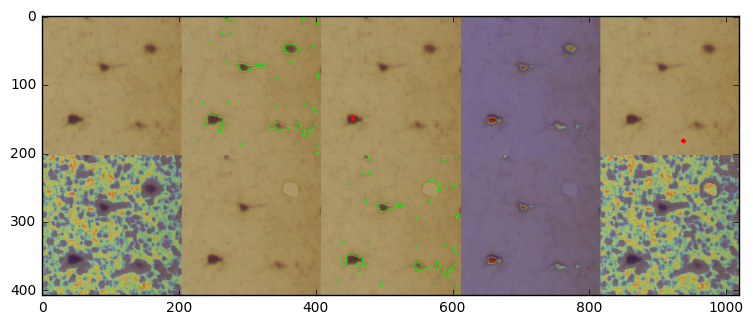

In [67]:
fig = plt.figure(figsize=(9,4))
plt.imshow(mosaic)
plt.show()